<div style="background-color:#173267;text-align:center;font-family:Arial;color:white;">
    <br>
    <img src="Files/logo-uc-01.svg" style="width:20%;margin:10px">
    <p style="font-size:40pt;font-weight:bold;text-align:center">
        AYUDANTÍA 10: Regresión Ridge/Lasso
    </p>
    <p style="font-size:20pt;font-weight:bold;margin:20px;text-align:center">
        Introducción a la Ciencia de Datos
    </p>
    <p style="font-size:12pt;text-align:center">
        Felipe Gutiérrez - figutier@uc.cl
        Nicolas Mendicoa - nmendicoa@uc.cl
        <br>18 de Octubre de 2022
    </p>
    <p style="text-align:center;font-family:Trebuchet MS;color:white;font-size:12pt;">        
        Basado en notebook de:
        Vicente Agüero - vicenteaguero@uc.cl
        <br>
    </p>
    <br><br>
</div>

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Regresión Ridge
Queremos solucionar el problema de overfitting. Para ello, Ridge usa una penalización, que hace que el modelo sea menos sensible a las variables explicativas.
Sabemos que la regresión lineal estándar busca minimizar los cuadrados de los residuales (OLS), pero ahora añadimos el término de penalty. 
$$\text{OLS} = \text{min} \sum_{i=1}^n(y_i - \hat{y_i} )^2$$
$$\text{Ridge} = \text{min} \sum_{i=1}^n(y_i - \hat{y_i} )^2 + \alpha \sum_{j=1}^p \beta_j^2$$

# Regresion Lasso
Es casi igual a la regresion Ridge, pero con otra norma ($l_1$).

$$\text{Lasso} = \text{min} \sum_{i=1}^n(y_i - \hat{y_i} )^2 + \alpha \sum_{j=1}^p |\beta_j|$$

Ridge y Lasso "fuerzan" que los coeficientes tiendan a 0.
Por un lado, Ridge reduce de forma proporcional todos los coeficientes. A medida que aumentamos $\alpha$, los coeficientes se acercan a 0. Por otro lado, Lasso reduce los coeficientes menos significativos, pudiendo estos llegar a 0. A medida que aumentamos $\alpha$, más coeficientes serán excluidos. 

Generalmente, vamos a querer usar Ridge Regression cuando tengamos datos con multicolinealidad (datos muy correlacionados). Intuitivamente, la multicolinealidad significa que tenemos más de una variable midiendo la misma cosa en un modelo. 

Generalmente usamos Lasso cuando queremos encontrar las variables explicativas menos significativas para eliminarlas del modelo. Lasso puede ser bastante malo en el caso de que tengamos variables correlacionadas.

# Ejercicio
Trabajemos con el mismo dataset de la ayudantía pasada

In [235]:
car = pd.read_csv('Files/car.csv')
car.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [236]:
train_cols = car.corr()[['price']].drop('price').abs()
train_cols = train_cols.loc[train_cols['price'] >= 0.5]
train_cols = train_cols.index.values
train_cols

x = car[train_cols]
y = car['price']
x.head()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg
0,88.6,168.8,64.1,2548,130,3.47,111,21,27
1,88.6,168.8,64.1,2548,130,3.47,111,21,27
2,94.5,171.2,65.5,2823,152,2.68,154,19,26
3,99.8,176.6,66.2,2337,109,3.19,102,24,30
4,99.4,176.6,66.4,2824,136,3.19,115,18,22


# VIF
El factor de inflación de la varianza (VIF) es una medida de multicolinealidad
$$ \text{VIF}_i = \frac{1}{1-R_i^2}$$
Donde $R_i$ es el $R^2$ de la regresión lineal que tiene $x_i$ como variable respuesta y las otras como explicativas. Es decir $$ x_i = \beta_0 + \beta_1 x_1 + ... + \beta_{i-1} x_{i-1} + \beta_{i+1} x_{i+1} + ... + \beta_n x_n + \varepsilon$$


Si el $\text{VIF}_i>10$, entonces tenemos multicolinealidad para la variable $i$.  Generalmente, no vamos a querer multicolinealidad, ya que dificulta interpretar coeficientes $\beta_i$. 

In [237]:
# VIF dataframe
x = add_constant(x)
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns

vif_data["VIF"] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]
vif_data

,feature,VIF
0,const,3271.689403
1,wheelbase,6.454355
2,carlength,8.784091
3,carwidth,5.168046
4,curbweight,12.706890
5,enginesize,5.381689
6,boreratio,1.854408
7,horsepower,6.415460
8,citympg,25.333385
9,highwaympg,23.793782


# Estandarizar/normalizar datos
Para usar Ridge/Lasso, es recomendable estandarizar datos. Podemos usar StandardScaler() o Normalizer() de sklearn, por ejemplo. Usaremos StandardScaler()

In [238]:
# Repaso de la ayudantia pasada
# Si tenemos un test_size muy pequeño, tendremos overfitting
# Aqui estamos FORZANDO un overfitting para efectos pedagogicos, generalmente van a querer usar test_size=0.2 0 0.3
x = x.loc[:, x.columns != 'const']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=0)
train_mean = x_train.mean()
train_std = x_train.std()

In [239]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(x_train)
x_test = (x_test - train_mean) / train_std #scaler.fit_transform(x_test)
x_train = pd.DataFrame(scaled_train, columns=train_cols)

x_test.head()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg
52,-0.944375,-1.254654,-0.825777,-1.269767,-0.862586,-1.116761,-0.954121,0.908163,1.083567
181,0.909789,1.078688,0.262747,1.093222,0.767308,-0.245387,1.330041,-0.941832,-0.945310
5,0.145353,0.225027,0.168093,-0.128098,0.185203,-0.535845,0.136047,-0.941832,-0.800390
18,-1.708811,-2.718074,-2.671535,-2.060591,-1.561112,-1.552448,-1.473249,3.374824,3.257364
188,-0.261262,-0.230260,-0.210524,-0.520665,-0.443470,-0.535845,-0.123517,0.137332,0.214048


# Pregunta
Por qué es importante usar StandardScaler en train y test por separado?

In [240]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [241]:
# R2 de train
print(lr.score(x_train,y_train))
# R2 de test
print(lr.score(x_test,y_test))
# El overfitting es claro: 0.83 de train vs 0.63 de test

0.8324389832357906
0.6366216564537566


# Ridge

In [242]:
ridge = Ridge(alpha=100)
ridge.fit(x_train, y_train)

Ridge(alpha=100)

In [243]:
print(ridge.score(x_train, y_train))
print(ridge.score(x_test, y_test))

0.7964397650470656
0.7142296104401409


Podemos ver que hay un $R^2$ en test bastante mejor a el resultado sin regularizacion.

Ahora grafiquemos como se ven los parametros

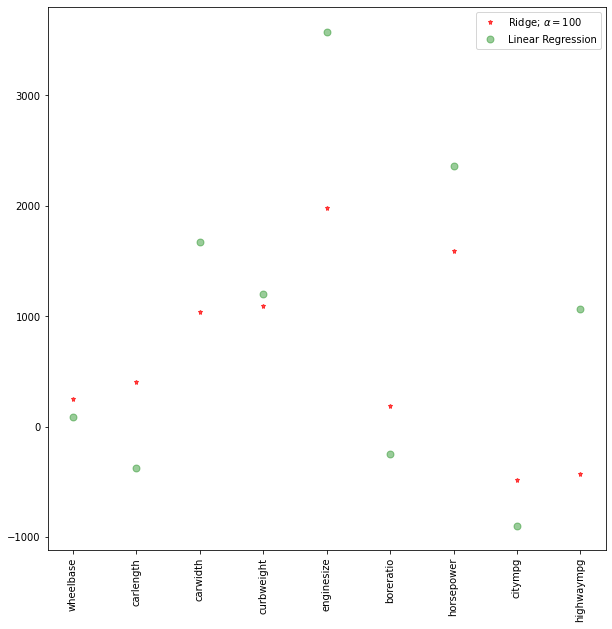

In [244]:
plt.figure(figsize = (10, 10))
plt.plot(train_cols,ridge.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 100$',zorder=7)
plt.plot(train_cols,lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [298]:
ridge_cv = RidgeCV(alphas=np.arange(1, 101, 1))
ridge_cv.fit(x_train, y_train)

print(ridge_cv.score(x_train, y_train))
print(ridge_cv.score(x_test, y_test))
print(f'El alpha optimo es: {ridge_cv.alpha_}')

0.830215989280706
0.6693483369707629
El alpha optimo es: 12


In [300]:
lr.coef_

array([  83.96010674, -370.01102498, 1670.9323182 , 1203.51184298,
       3577.8971187 , -247.33485966, 2357.1734595 , -896.89054616,
       1066.93403662])

In [299]:
ridge_cv.coef_

array([  12.18624575,  -33.67112052, 1453.07517124, 1213.4625277 ,
       3151.41892594, -158.26959512, 2267.6615502 , -258.6422225 ,
        176.80962163])

### Pregunta
Como podemos interpretar la diferencia en coeficientes?

In [297]:
ridge_cv = RidgeCV(alphas=np.arange(500, 1000, 1))
ridge_cv.fit(x_train, y_train)
print(ridge_cv.score(x_train, y_train))
print(ridge_cv.score(x_test, y_test))
print(f'El alpha optimo es: {ridge_cv.alpha_}')

0.6889742003946377
0.7004984943136787
El alpha optimo es: 500


In [286]:
ridge_cv = RidgeCV(alphas=np.arange(100, 200, 1))
ridge_cv.fit(x_train, y_train)
print(ridge_cv.score(x_train, y_train))
print(ridge_cv.score(x_test, y_test))
print(f'El alpha optimo es: {ridge_cv.alpha_}')

0.7964397650470663
0.7142296104401384
El alpha optimo es: 100


In [296]:
ridge_cv = RidgeCV(alphas=np.arange(1000, 5000, 10))
ridge_cv.fit(x_train, y_train)
print(ridge_cv.score(x_train, y_train))
print(ridge_cv.score(x_test, y_test))
print(ridge_cv.alpha_)

0.5853396783495006
0.6230049699618248
1000


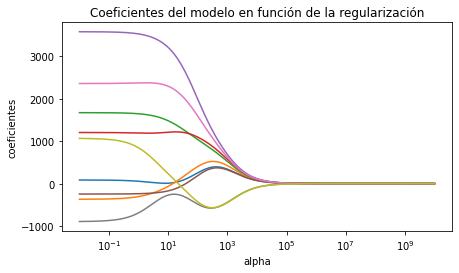

In [344]:
alphas = np.logspace(-2, 10, 200)
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha)
    modelo_temp.fit(x_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.axis('tight')
plt.show()

0.830392534475713
0.668154296895215
El alpha optimo es: 11.357333583431052


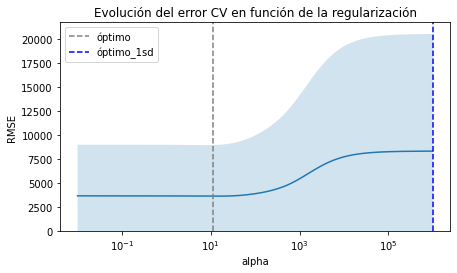

In [393]:
# El siguiente codigo lo saque de https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html
# Me parecio interesante ponerlo en la ayudantia, y si quieren profundizar mas del tema pueden ir a ese link.
ridge_cv = RidgeCV(alphas=np.logspace(-2, 6, 200), store_cv_values = True)
ridge_cv.fit(x_train, y_train)
print(ridge_cv.score(x_train, y_train))
print(ridge_cv.score(x_test, y_test))
print(f'El alpha optimo es: {ridge_cv.alpha_}')
mse_cv = ridge_cv.cv_values_.mean(axis=0)
mse_sd = ridge_cv.cv_values_.std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = ridge_cv.alphas[np.argmin(rmse_cv)]
optimo_1sd   = ridge_cv.alphas[rmse_cv == min_rsme_1sd]


# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(ridge_cv.alphas, rmse_cv)
ax.fill_between(
    ridge_cv.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()

In [ ]:
ridge_cv = RidgeCV(alphas=np.arange(1, 101, 1))
ridge_cv.fit(x_train, y_train)

print(ridge_cv.score(x_train, y_train))
print(ridge_cv.score(x_test, y_test))
print(f'El alpha optimo es: {ridge_cv.alpha_}')

# Lasso

In [288]:
lasso = Lasso(alpha=100)
lasso.fit(x_train, y_train)
print(lasso.score(x_train, y_train))
print(lasso.score(x_test, y_test))

0.8306657198909455
0.6562530585873777


In [289]:
lasso_cv = LassoCV(alphas=np.arange(1, 300, 1), n_jobs=-1)
lasso_cv.fit(x_train, y_train)
print(lasso_cv.score(x_train, y_train))
print(lasso_cv.score(x_test, y_test))
print(lasso_cv.alpha_)

0.8303145855643396
0.6652982296399725
171


In [290]:
lasso_cv = LassoCV(alphas=np.arange(500, 1000, 1), n_jobs=-1)
lasso_cv.fit(x_train, y_train)
print(lasso_cv.score(x_train, y_train))
print(lasso_cv.score(x_test, y_test))
print(lasso_cv.alpha_)

0.8262879334480141
0.7008071316105713
500


In [291]:
lasso_cv = LassoCV(alphas=np.arange(1000, 5000, 10), n_jobs=-1)
lasso_cv.fit(x_train, y_train)
print(lasso_cv.score(x_train, y_train))
print(lasso_cv.score(x_test, y_test))
print(lasso_cv.alpha_)

0.8126098771060224
0.734651195089246
1000


In [294]:
lasso_cv = LassoCV(alphas=np.arange(1, 5000, 1), n_jobs=-1)
lasso_cv.fit(x_train, y_train)
print(lasso_cv.score(x_train, y_train))
print(lasso_cv.score(x_test, y_test))
print(lasso_cv.alpha_)

0.8303145855643396
0.6652982296399725
171


In [295]:
lasso_cv.coef_

array([   0.        ,    0.        , 1448.3493008 ,  682.74164422,
       3604.690494  ,   -0.        , 2256.07655195,   -0.        ,
         -0.        ])

### Pregunta
Cual es la interpretacion de los coeficientes anteriores?

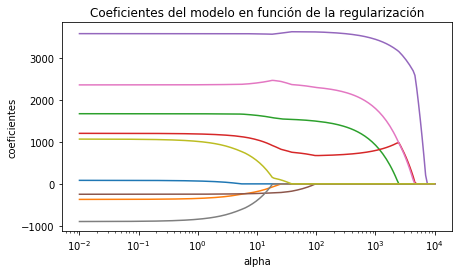

In [337]:
alphas = np.logspace(-2, 4, 200)
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha)
    modelo_temp.fit(x_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.axis('tight')
plt.show()

In [338]:
coefs[-1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.])

0.8303429826514697
0.664725389835022
166.38168860761274


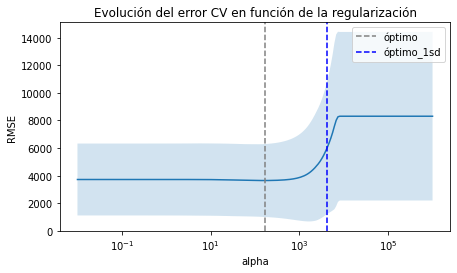

In [388]:
lasso_cv = LassoCV(alphas=np.logspace(-2, 6, 200), n_jobs=-1, cv= 10)
lasso_cv.fit(x_train, y_train)
print(lasso_cv.score(x_train, y_train))
print(lasso_cv.score(x_test, y_test))
print(lasso_cv.alpha_)
mse_cv = lasso_cv.mse_path_.mean(axis=1)
mse_sd = lasso_cv.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = lasso_cv.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = lasso_cv.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(lasso_cv.alphas_, rmse_cv)
ax.fill_between(
    lasso_cv.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()

# Ejercicio propuesto 1
Haga el mismo análisis de Ridge/Lasso, pero normalice los datos con Normalizer().

# Ejercicio propuesto 2
Haga un analisis de VIF para el dataset 'newhousing.csv'. Hay multicolinealidad? Haga una regresion lineal sin penalización, y luego haga cross validation con Ridge y Lasso. Qué puede decir de los resultados?

# Ejercicio propuesto 3
$\text{ElasticNet}$ es un modelo que mezcla las penalizaciones $l_1$ y $l_2$. Haga un modelo con ElasticNet para 'car.csv'. Como cambia el modelo a medida que cambiamos los parametros? Como se compara con Ridge y Lasso?

In [316]:
from sklearn.linear_model import ElasticNet, ElasticNetCV